# FDA

---

## Function-on-scalar regression model

**Question of interest :** Is there any relationship between the weight loss and the activity counts?

We can use a scalar-on-function regression model to answer this question:  
$$Y_i = \mu_Y + \int{Act_i(t)\beta(t)} +\epsilon_i(t)$$

where $Act_i(t)$ is modeled using fPCA, $Act_i(t) = \mu(t) + \sum_{k=1}^\infty{\xi_{ik}\phi_k(t)}$

## Load input: packages, external functions, input data.

### Packages

In [9]:
# Libraries
library(fda)
library(fdANOVA)
library(tidyverse)
library(dplyr)
library(refund)
library(refund.shiny)
#theme_set(theme_bw() + theme(legend.position = "bottom"))
library(ggplot2)
library(fields)
library(mgcv)

### Data

In [93]:
# Read cvs file
# df = read_csv("../../../data/fda/mBaselineSteps60.csv");
# df = read_csv("../../../data/fda/mVisitBaseline_60_Acc.csv");
# dfAcc = read_csv("../../../data/fda/mVisit32w_60_Acc.csv");
# df = read_csv("../../../data/fda/mVisit6wPP_60_Acc.csv");
# df = read_csv("../../../data/fda/mVisit6mPP_60_Acc.csv");
# df = read_csv("../../../data/fda/mVisit12mPP_60_Acc.csv")
df = read_csv("../../../data/fda/mVisit32w-VisitBaseline_60_Acc.csv");
dfWeight = read_csv("../../../data/fda/weightChange21.csv");


names(dfAcc)[names(dfAcc)=="studyID"] <- "id"
dfAcc$id <- as.character(dfAcc$id)
head(dfAcc, 3)

names(dfWeight)[names(dfWeight)=="studyID"] <- "id"
dfWeight$id <- as.character(dfWeight$id)
head(dfWeight, 3)



-- Column specification ------------------------------------------------------------------------------------------------
cols(
  .default = col_double()
)
i Use `spec()` for the full column specifications.



-- Column specification ------------------------------------------------------------------------------------------------
cols(
  studyID = col_double(),
  weightRatio = col_double()
)




id,arm,T00h00,T01h00,T02h00,T03h00,T04h00,T05h00,T06h00,T07h00,...,T14h00,T15h00,T16h00,T17h00,T18h00,T19h00,T20h00,T21h00,T22h00,T23h00
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,3,766.8571,76.28571,248.5714,314.2857,104.5714,260.2857,314.2857,2060.00,...,6925.571,5428.857,5170.286,3253.00,3900.286,4328.714,6462.429,5043,32.14286,432.000
18,1,28774.8333,3164.83333,4179.6667,4172.5000,3599.3333,8289.0000,38356.3333,18199.00,...,19682.667,32323.000,24117.333,28279.33,33791.000,35362.167,49850.667,27779,16279.66667,29627.833
43,2,1361.8571,1803.14286,828.5714,1351.4286,822.0000,7100.8571,10687.8571,13208.71,...,24584.857,31278.000,20531.429,17190.57,22813.857,32857.714,14395.000,11778,7280.00000,4676.143


id,weightRatio
<chr>,<dbl>
4,1.153191
43,1.174367
44,1.074913


Joint data frame according to dfWeight:

In [94]:
df <- left_join(dfWeight, dfAcc, by = "id")
head(df, 3)

id,weightRatio,arm,T00h00,T01h00,T02h00,T03h00,T04h00,T05h00,T06h00,...,T14h00,T15h00,T16h00,T17h00,T18h00,T19h00,T20h00,T21h00,T22h00,T23h00
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,1.153191,3,766.8571,76.28571,248.5714,314.2857,104.5714,260.2857,314.2857,...,6925.571,5428.857,5170.286,3253.00,3900.286,4328.714,6462.429,5043.00,32.14286,432.000
43,1.174367,2,1361.8571,1803.14286,828.5714,1351.4286,822.0000,7100.8571,10687.8571,...,24584.857,31278.000,20531.429,17190.57,22813.857,32857.714,14395.000,11778.00,7280.00000,4676.143
44,1.074913,3,6945.0000,5142.28571,2158.4286,237.2857,358.5714,354.1429,462.8571,...,19570.857,16532.714,18475.429,13766.00,14840.143,18610.857,16572.571,12232.71,11197.85714,16420.714


In [95]:
filter(df, id == "151" )

id,weightRatio,arm,T00h00,T01h00,T02h00,T03h00,T04h00,T05h00,T06h00,...,T14h00,T15h00,T16h00,T17h00,T18h00,T19h00,T20h00,T21h00,T22h00,T23h00
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
151,1.12051,1,2271.857,1906.429,1729,2584.429,7493.143,29931.43,19565.86,...,16292.43,21937.86,22330,24246.71,18600,17603.29,11605.71,3734.857,3933,1962


## Functional principal components (FPC) regression

We fit functional linear regression by assuming $\beta(t) = \sum_{k=1}^\infty{\beta_k\phi_k(t)}$

### Define response and covariate:

In [96]:
# Create temporal axis depending on the resolution of the data
time <- 1:(dim(df)[2]-3)
n <- dim(df)[1]

X <- as.matrix(df[,c(4:dim(df)[2])]) # functional covariate: physical activity
Y <- as.vector(df$weightRatio) # scalar response: weight change

# myDat <- data.frame(X = X)
# myDat$Y <- Y

dim(X);length(Y)

[1] 181  24

[1] 181

### Run fPCA on the functional covariate using fpca.sc in refund package.
`fpca.sc` decomposes functional observations using functional principal components analysis. A mixed model framework is used to estimate scores and obtain variance estimates.

In [97]:
fpca_res <- fpca.sc(X, argvals = time, pve = 0.99) # pve is the proportion of variance explained: used to choose the number of principal components.

m <- length(time)
efn <- fpca_res$efunctions*sqrt(m) # estimated eigenfunctions
evals <- fpca_res$evalues/m # estimated eigen values 
scr <- fpca_res$scores/sqrt(m) # estimated FPC scores
npc <- fpca_res$npc # number of principal component needed to explain proportion pve of the variance in the observed curves 

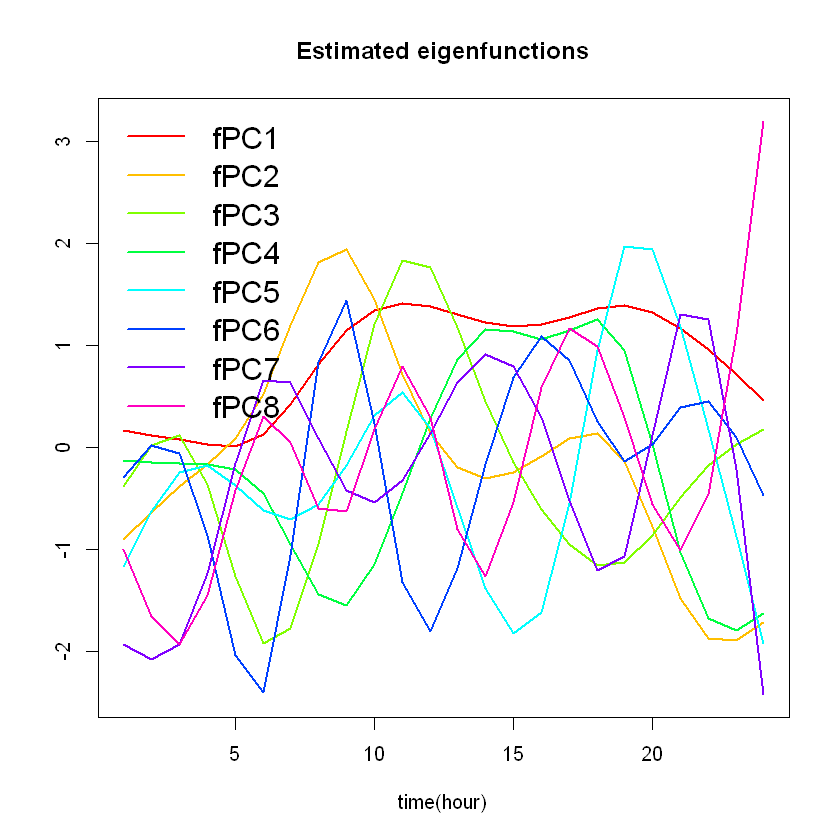

In [98]:
matplot(time, efn, type='l', lty=1, lwd=2,
        col=rainbow(fpca_res$npc),
        main = "Estimated eigenfunctions", ylab="",
        xlab = "time(hour)")
legend("topleft", col = rainbow(fpca_res$npc), 
       lwd=2, lty=1, legend = paste0("fPC", 1:fpca_res$npc),
       cex = 1.5, bty = "n")

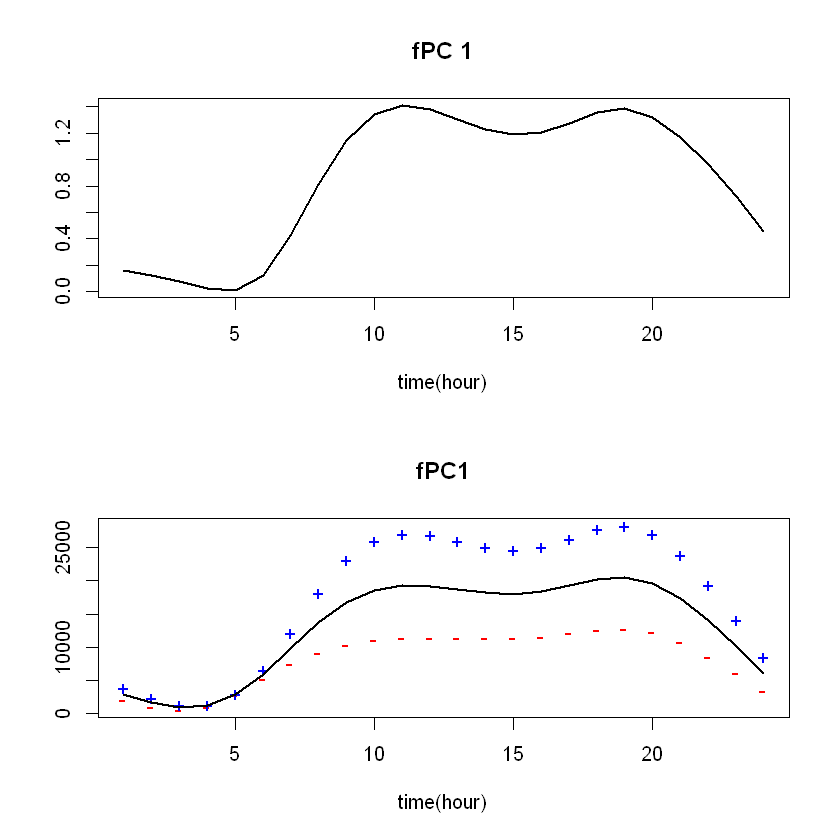

In [99]:
kPC <- 1
effect <- sqrt(evals[kPC])*efn[,kPC]
mu_hat <- fpca_res$mu # estimated mean function

par(mfrow = c(2,1))
plot(time, efn[,kPC], type='l', lwd=2, lty=1, 
     xlab = "time(hour)", ylab="", main = paste("fPC", kPC))

matplot(time, cbind(mu_hat-effect, mu_hat+effect), 
        col=c("red", "blue"), pch = c("-", "+"),
        main = paste0("fPC", kPC), 
        xlab = "time(hour)", ylab="")
lines(time, mu_hat, lwd=2)

### Multiple linear regression on the vector of scalar response weight change

In [100]:
out = lm(Y ~ scr) ## Multiple linear regression
# summary(out)

In [101]:
beta_hat = out$coefficients
beta_hat

(Intercept)          scr1          scr2          scr3          scr4 
 1.125364e+00 -2.025459e-06 -5.240635e-07 -4.881455e-06 -3.279082e-06 
         scr5          scr6          scr7          scr8 
-6.533834e-06  1.015923e-05 -1.180324e-05  2.452119e-05

Since fPCA selected the first 6 principal componenets based on the specified percentage of variance explained, we have 6 corresponding basis coefficients.

Let reconstruct the regression coefficient function:

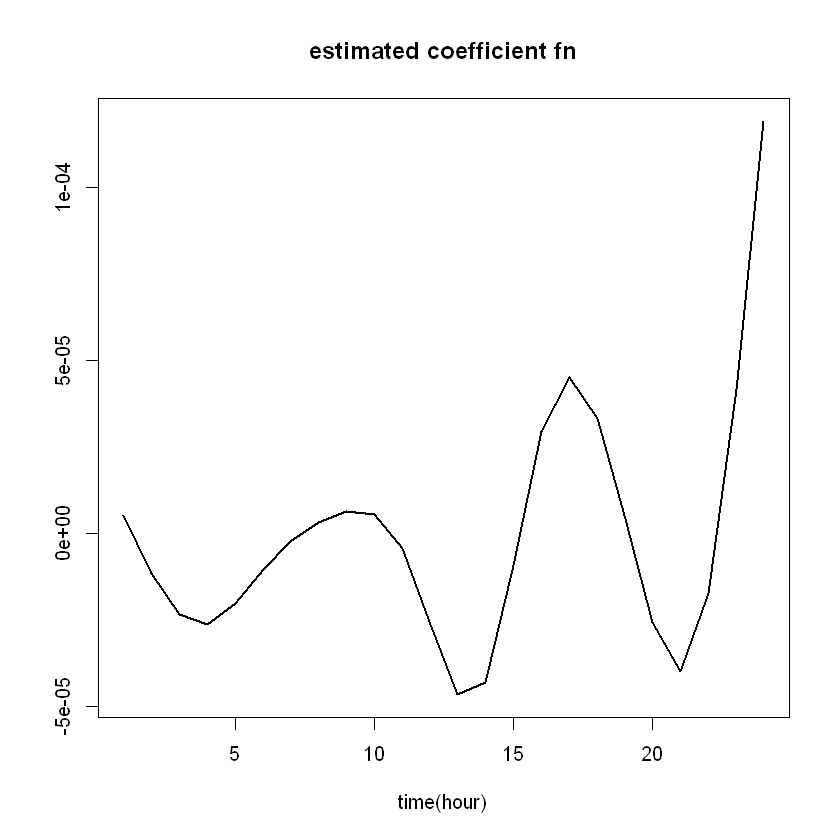

In [102]:
par(mfrow=c(1,1))
beta_fn_hat  = efn %*% as.matrix(beta_hat[-1], col=1)
plot(time, beta_fn_hat, type='l', lwd=2,
     xlab="time(hour)", ylab = "", main="estimated coefficient fn")

Let’s focus on looking at three random activity profiles:

In [103]:
set.seed(123)
nCrv <- 3
selCrv <- sample(1:n, size = nCrv, replace = FALSE)
selCrv

[1] 159 179  14

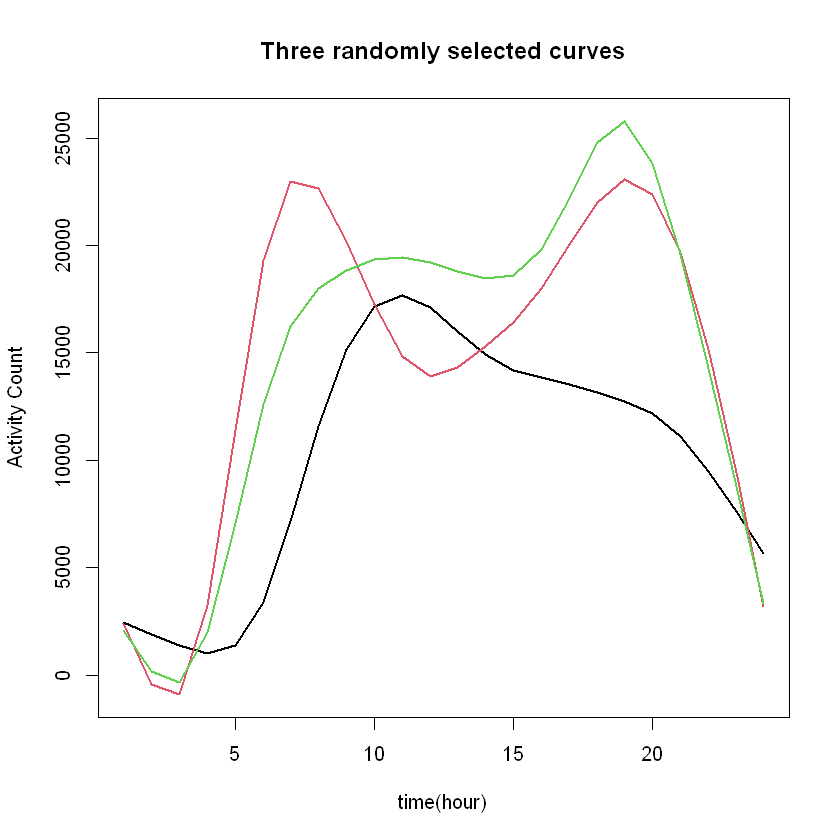

In [104]:
matplot(time, t(fpca_res$Yhat[selCrv,]), type='l', lwd=2, lty=1,
        xlab="time(hour)", ylab="Activity Count", main="Three randomly selected curves")

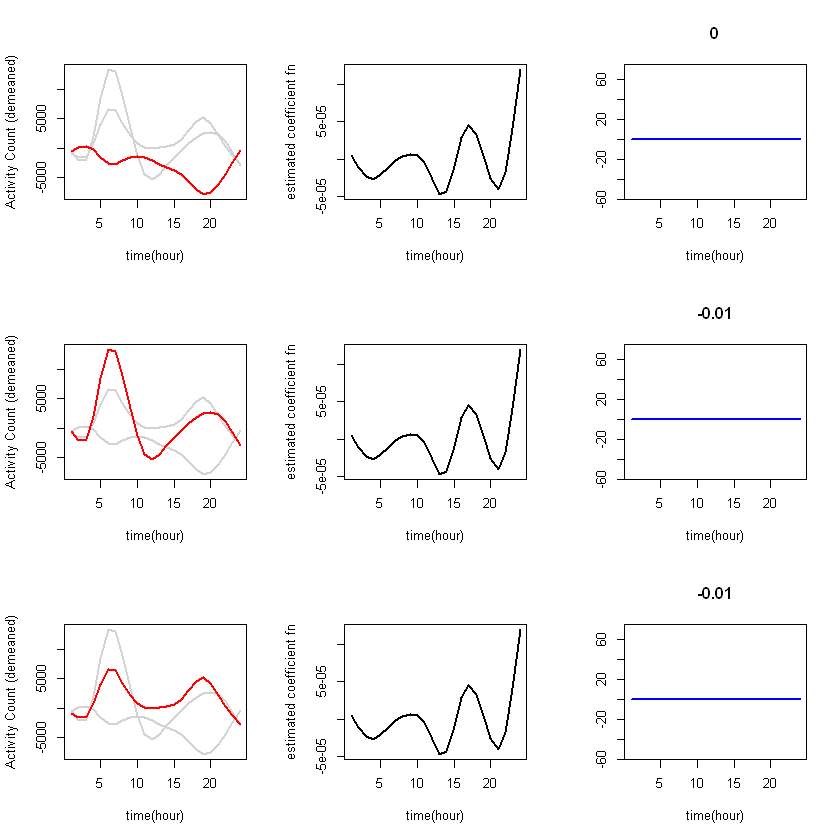

In [105]:
par(mfrow=c(3,3))
for(i in 1:3){
    ind <- selCrv[i]
    demeaned <- fpca_res$Yhat[ind,] - as.vector(fpca_res$mu)
    
    matplot(time, t(fpca_res$Yhat[selCrv,] - t(matrix(rep(fpca_res$mu,3), nrow= m))), 
            type='l', lwd=2, lty=1, col = 'light grey',
        xlab="time(hour)", ylab="Activity Count (demeaned)", main="")
    lines(time, demeaned, type='l', lwd=2, col='red')
    

    plot(time, beta_fn_hat, type='l', lwd=2,
         xlab="time(hour)", ylab = "estimated coefficient fn", main="")
    plot(time, demeaned*beta_fn_hat,type='l', lwd=2, col='blue',
         xlab="time(hour)", ylab = "", ylim=c(-55, 70),
         main=round(mean(demeaned*beta_fn_hat), 2))
}

### Goodness-of-fit

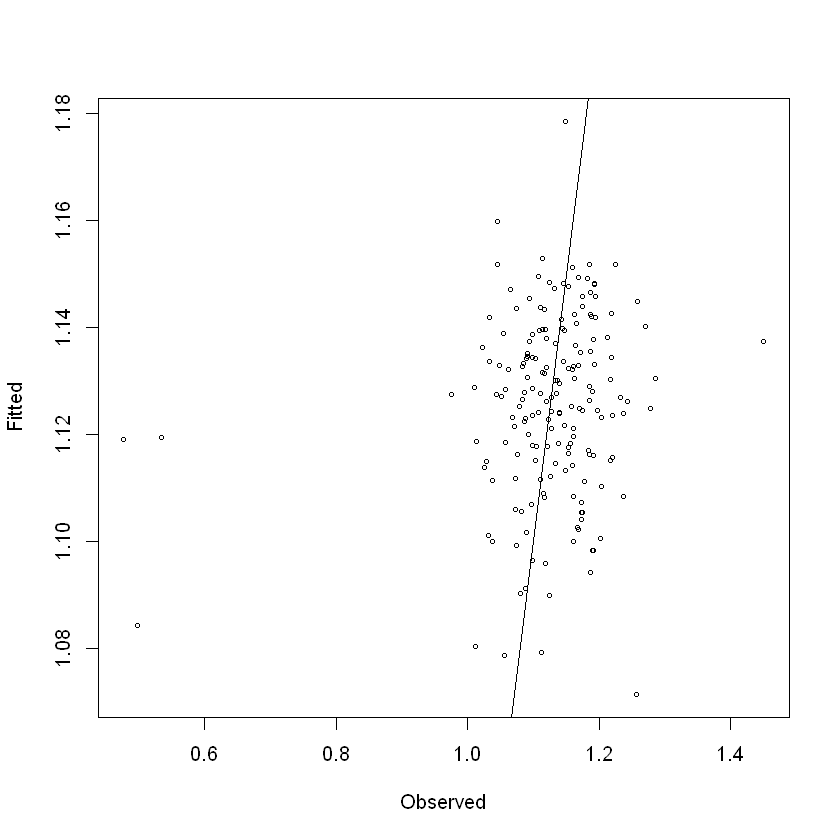

In [106]:
par(mfrow=c(1,1))
plot(Y, out$fitted, cex=0.5, ylab="Fitted", xlab="Observed")
abline(a = 0, b = 1)

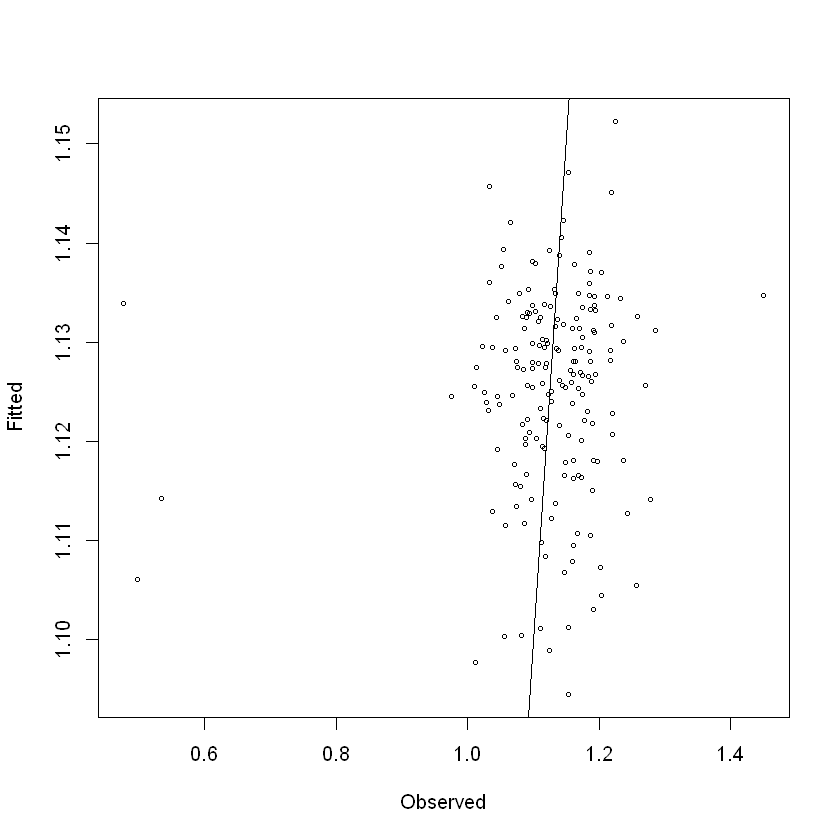

In [107]:
fpca_res <- fpca.sc(X, argvals = time, pve = 0.97)
Xhat <- fpca_res$Yhat
Yhat <- predict(fit, newdata = list(X = Xhat))

# goodness-of-fit
par(mfrow=c(1,1))
plot(Y, Yhat, cex=0.5, ylab="Fitted", xlab="Observed")
abline(a = 0, b = 1)

Calculate R-squared:

In [108]:
Rsq = 1-sum((out$residuals)^2)/sum((Y- mean(Y))^2)
Rsq

[1] 0.02811374

## Functional linear model with mixed basis

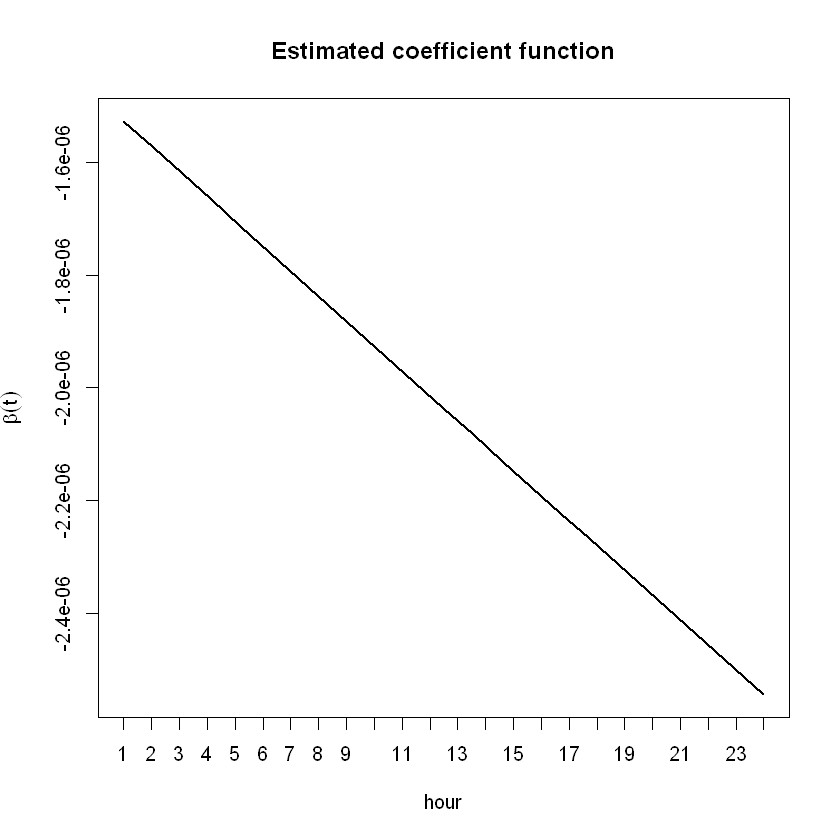

In [111]:
myDat <- data.frame(X, Y)
fit <- pfr(Y ~ lf(X, k = 10, bs = "ps", presmooth="bspline"), method = "REML", data = myDat)
coef <- coef(fit)


plot(coef$X.argvals, coef$value, ylab=expression(paste(beta(t))), 
     xlab="hour", xaxt = 'n', type='l', lwd=2,
     main="Estimated coefficient function")
axis(side = 1, at = seq(0,1,length.out = m), label=1:m)

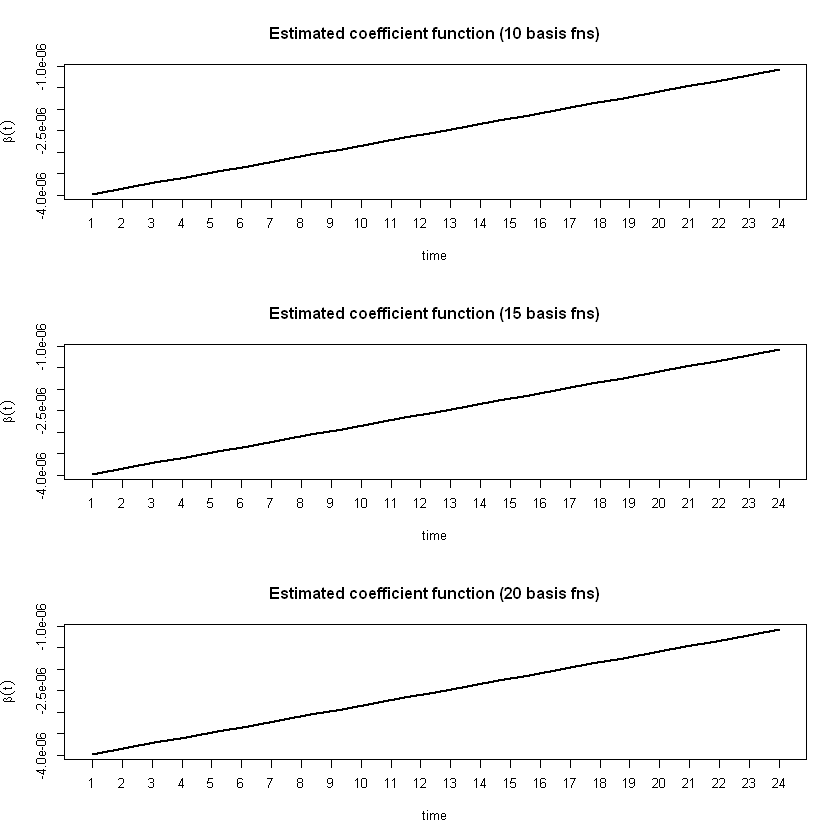

In [110]:
par(mfrow=c(3,1))
for(k in c(10, 15, 20)){
 fit <- pfr(Y ~ lf(X, k = k, bs = "cr"), method = "REML", data = myDat)
 coef <- coef(fit)


plot(coef$X.argvals, coef$value, ylab=expression(paste(beta(t))), 
     xlab="time", xaxt = 'n', type='l', lwd=2,
     main= paste0("Estimated coefficient function (", k, " basis fns)"))
axis(side = 1, at = seq(0,1,length.out = m), label=1:m)
 
}

In [113]:
df[,c(2,3)] %>% group_by(arm)

weightRatio,arm
<dbl>,<dbl>
1.153191,3
1.174367,2
1.074913,3
1.166667,1
1.127976,3
1.114168,1
1.201320,2
1.173804,2
1.133945,3
